# LightGBM

O LightGBM é um tipo de algoritmo usado para modelos de Aprendizagem de Máquina (AM), que utiliza várias árvores para fazer suas previsões, além de dar um "boosting", uma impulsionada para o código.

Cada vez que o modelo adiciona uma nova árvore, ela corrige a anterior, tornando seu modelo mais robusto.

<center>

![image.png](../figures/light_gbm.png)

</center>

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix, make_scorer, recall_score

## Lendo o Dataset tratado, transformando-o em um DataFrame e armazenando nas variáveis, as colunas referentes as suas características e rótulos

In [4]:
df = pd.read_csv('dataset_tratado.csv')

X = df.drop('ZSN', axis=1)  # Armazenando todas as colunas de características, exceto a última pois ela é a coluna de rótulo
y = df['ZSN']               # Armazenado a última coluna, que será o nosso rótulo

## Treinando o modelo, usando 20% dos dados para teste e o restante para treino

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

## Pegando os parâmetros usandos e classificando-os

Parte que ajusta o comportamento do modelo com base na sua personalização, dessa forma, isso torna o modelo mais eficiente de acordo com o que se espera dele

In [6]:
params = {
    'objective': 'binary',      # Define o objetivo da tarefa de aprendizado (regressão ou clasificação)
    'metric': 'binary_error',   # Parte que avalia o desempenho do modelo durante o treinamento, calcula a qualidade das previsões de cada iteração
    'boosting_type': 'gbdt',    # Define o tipo de boosting a ser usado (gbdt, rf, dart, goss)
    'num_leaves': 35,           # Número máximo de folhas em uma árvore
    'learning_rate': 0.05,      # Taxa de aprendizado que contrala a contribuição de cada árvore no modelo
    'feature_fraction': 0.9     # Fração de featurs a serem consideradas em cada iteração para treinar a árvore
}

## Parte dedicada para as métricas do código

[LightGBM] [Info] Number of positive: 314, number of negative: 1046
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.074574 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 504
[LightGBM] [Info] Number of data points in the train set: 1360, number of used features: 70
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.230882 -> initscore=-1.203336
[LightGBM] [Info] Start training from score -1.203336


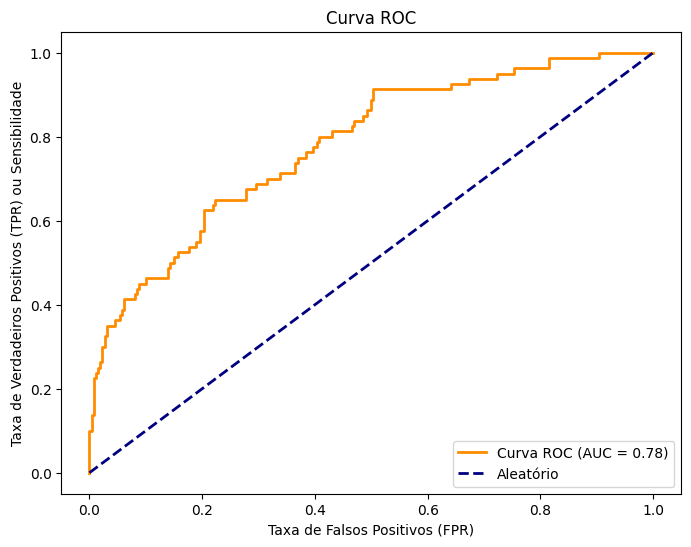

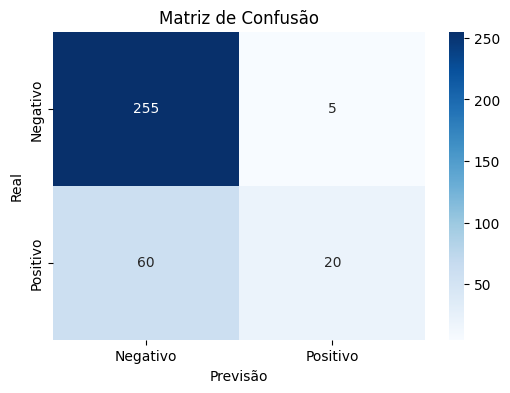

              precision    recall  f1-score   support

           0       0.81      0.98      0.89       260
           1       0.80      0.25      0.38        80

    accuracy                           0.81       340
   macro avg       0.80      0.62      0.63       340
weighted avg       0.81      0.81      0.77       340



In [7]:
num_round = 100
bst = lgb.train(params, train_data, num_round, valid_sets=[test_data])

y_probs = bst.predict(X_test, num_iteration=bst.best_iteration)

# Calcular a curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Plotar a curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aleatório')
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR) ou Sensibilidade')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

# Calcular e plotar a matriz de confusão
y_pred_binary = [1 if prob > 0.5 else 0 for prob in y_probs]
cm = confusion_matrix(y_test, y_pred_binary)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negativo', 'Positivo'], yticklabels=['Negativo', 'Positivo'])
plt.xlabel('Previsão')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# Imprimir relatório de classificação
print(classification_report(y_test, y_pred_binary, zero_division=0))

In [8]:
probs_test = pd.DataFrame(y_probs, columns=['ZSN'])


In [9]:
probs_test.shape

(340, 1)

In [10]:
y_test.shape

(340,)

In [11]:
probs_test.index

RangeIndex(start=0, stop=340, step=1)

In [12]:
y_test.reset_index(drop=True)

0      1
1      0
2      0
3      0
4      0
      ..
335    0
336    1
337    0
338    0
339    0
Name: ZSN, Length: 340, dtype: int64

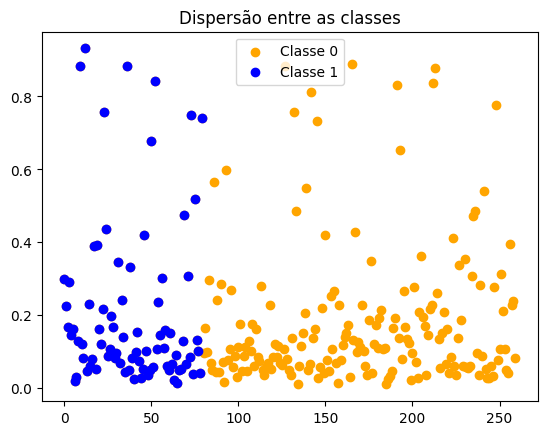

In [13]:
for label in [0, 1]:
    color = 'orange' if label == 0 else "blue"
    class_label = 'Classe 0' if label == 0 else 'Classe 1'
    df_label = y_test[y_test.isin([label])]
    df_probs = probs_test.iloc[df_label.reset_index(drop=True).index]
    
    plt.scatter(x=range(len(df_label)), y=df_probs, c=color, label=class_label)
plt.title('Dispersão entre as classes')
plt.xlabel('Índice')
plt.ylabel('Probabilidade')
plt.legend()
plt.show()